In [1]:
import torch
import torchvision as tv
from torchvision.transforms import transforms

import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from acflow import RealNVP

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
batch_size = 1
def get_mnist(batch_size):
  transform = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize((0.1307,), (0.30811,))
    ]
  )

  train_set = tv.datasets.MNIST(
    '../data/', train=True, download=True, transform=transform
  )
  test_set = tv.datasets.MNIST(
    '../data/', train=False, download=True, transform=transform
  )

  train_loader = torch.utils.data.DataLoader(
    train_set, batch_size
  )
  test_loader = torch.utils.data.DataLoader(
    test_set, batch_size
  )

  return train_loader, test_loader, train_set, test_set
train_loader, test_loader, train_set, test_set = get_mnist(batch_size)

In [10]:
layers = 3

model = RealNVP(
  1, 5, layers, 10, (1,28,28), device, 20
).to(device)
model.load_state_dict(torch.load('chkpt/mnist_gmm_rand_3_1e-10.tar')['model_state_dict'])
# sum(p.numel() for p in model.parameters())

<All keys matched successfully>

In [11]:
for x,y in train_loader:
  
  x = x.to(device)
  running_det = 0

  for i, flow in enumerate(model.flows):
    x, det = flow.f(x,  i%2 + (-1)**i * model.mask)
    running_det += det
    # print(f'{det}')
    print(running_det)

  loss = model.log_prob(x)
  loss1 = -loss[0].mean()
  print(loss)
  print(loss1)
  break

tensor([56.9582], device='cuda:0', grad_fn=<AddBackward0>)
tensor([190.3651], device='cuda:0', grad_fn=<AddBackward0>)
tensor([23.6896], device='cuda:0', grad_fn=<AddBackward0>)
tensor([-147440.8281], device='cuda:0', grad_fn=<SubBackward0>)
tensor(147440.8281, device='cuda:0', grad_fn=<NegBackward>)


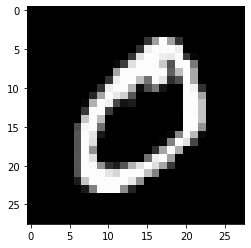

In [12]:
x1 = train_set[1]
plt.imshow(x1[0][0], cmap='gray')
plt.show()

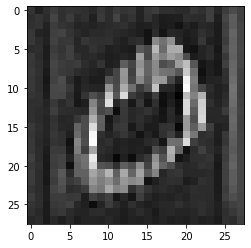

In [13]:
z1, det = model(x1[0].to(device))
plt.imshow(z1.cpu().detach().numpy()[0][0], cmap='gray')
plt.show()

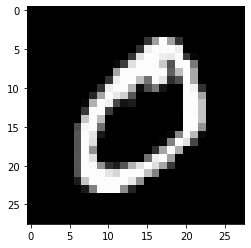

In [14]:
x2 = model.reverse(z1)
plt.imshow(x2.cpu().detach().numpy()[0][0], cmap='gray')
plt.show()

In [8]:
np.max(x1[0].cpu().detach().numpy()[0][0] - x2.cpu().detach().numpy()[0][0])

1.1920929e-06

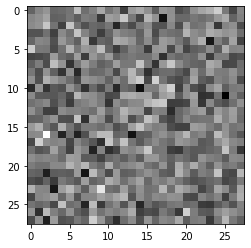

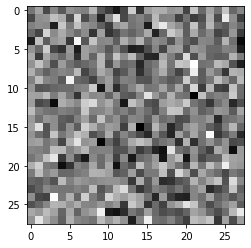

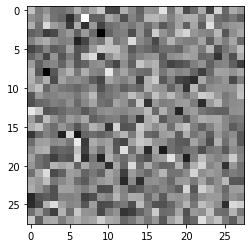

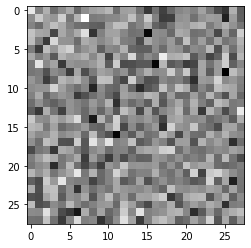

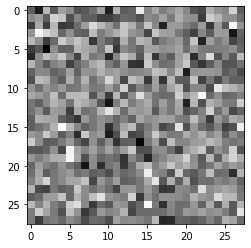

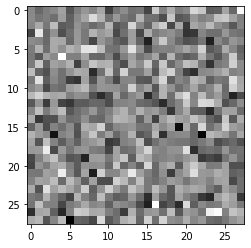

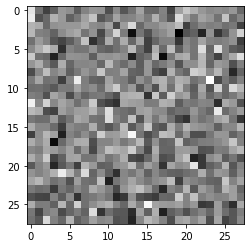

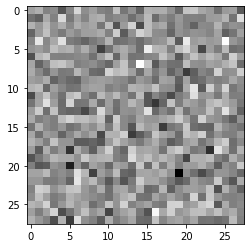

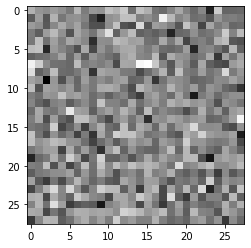

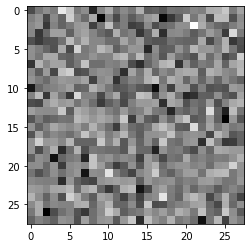

In [9]:
for mean in model.means:
  plt.imshow(mean.cpu().detach().numpy().reshape((28,28)), cmap='gray')
  plt.show()

In [10]:
model.means[0].size()

torch.Size([784])